<h1> Clusterization with y1 + GBR </h1>

In [1]:
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler
import numpy as np

# read datasets
train_df = pd.read_csv('data/train2.csv')
test_df = pd.read_csv('data/test2.csv')

y1_name, y2_name, y3_name = "dir_costs", "traffic_costs_s_r", "lost_trips_costs_s_r"
train_y1, train_y2, train_y3 = train_df[y1_name], train_df[y2_name], train_df[y3_name]
test_y1, test_y2, test_y3 = test_df[y1_name], test_df[y2_name], test_df[y3_name]

# scale features
X_train = train_df.drop(columns=[y1_name, y2_name, y3_name])
scaler = MaxAbsScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

X_test = test_df.drop(columns=[y1_name, y2_name, y3_name])
X_test = scaler.transform(X_test)

# prepare dataset from training kmeans
X_train_y3 = np.concatenate((X_train, train_df[y3_name].values.reshape(-1, 1)), axis=1)
scaler_y3 = MaxAbsScaler()
scaler_y3.fit(X_train_y3)
X_train_y3 = scaler_y3.transform(X_train_y3)

<h1> Pick optimal number of clusters (Elbow method) </h1>


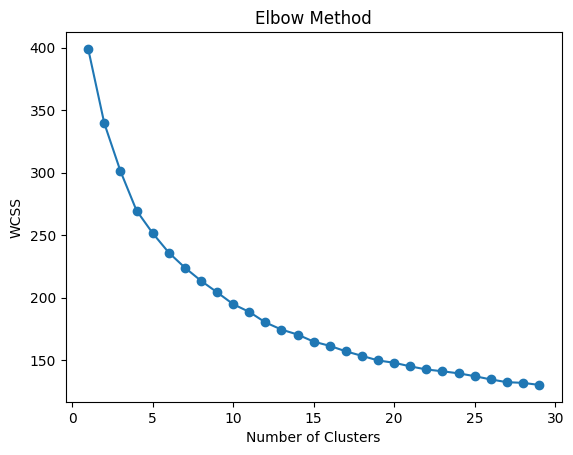

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a range of cluster numbers
cluster_range = range(1, 30)
wcss = []

# Calculate WCSS for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_train_y3)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

<h1> Train kmeans with y3 </h1>

In [3]:
from sklearn.cluster import KMeans

clusters_num = 4
kmeans = KMeans(n_clusters=clusters_num, random_state=42, n_init=10)
kmeans.fit(X_train_y3)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [4]:
import numpy as np
# transforms X into clustered dataset with. k - number of clusters in the range [0, k-1]
def transform_to_clustered_dataset_train(X: np.ndarray, Xy: pd.DataFrame, cluster_predictor, k: int):
    clusters = cluster_predictor.predict(Xy)
    zero_columns = pd.DataFrame(np.zeros((X.shape[0], k)), columns=[f'class_{i}' for i in range(k)])
    res = np.concatenate((X, zero_columns), axis=1)
    for i in range(res.shape[0]):
        cluster = clusters[i]
        res[i, X.shape[1] + cluster] = 1.0 
    return res

def transform_to_clustered_dataset_test(X: np.ndarray, kmeans_model: KMeans, k: int):
    centers = kmeans_model.cluster_centers_[:, :-1]
    clusters = []
    for row in X:
        min_dist = np.Infinity
        cluster = -1
        for i in range(k):
            cur_dist = np.linalg.norm(row - centers[i])
            if cur_dist < min_dist:
                min_dist = cur_dist
                cluster = i
        if cluster == -1:
            raise "Error"
        clusters.append(cluster)
        
    zero_columns = pd.DataFrame(np.zeros((X.shape[0], k)), columns=[f'class_{i}' for i in range(k)])
    res = np.concatenate((X, zero_columns), axis=1)
    for i in range(res.shape[0]):
        cluster = clusters[i]
        res[i, X.shape[1] + cluster] = 1.0 
    return res
            

In [5]:
X_train_clustered = transform_to_clustered_dataset_train(X_train, X_train_y3, kmeans, clusters_num)
X_test_clustered = transform_to_clustered_dataset_test(X_test, kmeans, clusters_num)

In [6]:
X_train_clustered

array([[0.47768174, 0.82396772, 0.45846266, ..., 0.        , 0.        ,
        0.        ],
       [0.41691199, 0.85767555, 0.35664933, ..., 0.        , 0.        ,
        1.        ],
       [0.87532125, 0.83275955, 0.45961423, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.48669484, 0.82904474, 0.39619957, ..., 0.        , 1.        ,
        0.        ],
       [0.43717206, 0.8248532 , 0.56394459, ..., 0.        , 0.        ,
        0.        ],
       [0.49764223, 0.83218448, 0.40092679, ..., 1.        , 0.        ,
        0.        ]])

In [7]:
X_test_clustered

array([[0.44960484, 0.8218743 , 0.29171249, ..., 0.        , 0.        ,
        0.        ],
       [0.47736132, 0.83002958, 0.29802562, ..., 1.        , 0.        ,
        0.        ],
       [0.49620336, 0.80079327, 0.40616336, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.39538033, 0.83965478, 0.32543884, ..., 0.        , 1.        ,
        0.        ],
       [0.59300771, 0.8340513 , 0.36733739, ..., 1.        , 0.        ,
        0.        ],
       [0.50605131, 0.82906921, 0.39542077, ..., 1.        , 0.        ,
        0.        ]])

<h1> GBR with arbitrary hyperparameters </h1>

In [8]:
from metrics import print_metrics
from sklearn.ensemble import GradientBoostingRegressor

# Create an instance of GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=48, learning_rate=0.096952, max_depth=6, random_state=42)

# Fit the regressor to the training data
gb_regressor.fit(X_train_clustered, train_y3)

print("------ test metrics ------")
print_metrics(test_y3, gb_regressor.predict(X_test_clustered))

print("------ train metrics ------")
print_metrics(train_y3, gb_regressor.predict(X_train_clustered))

------ test metrics ------
Mean Squared Error (MSE):              922741340363834.5000000000
Root Mean Squared Error (RMSE):        30376657.8208306916
Mean Absolute Error (MAE):             15885446.8439574316
R-squared (R²):                        0.6339005714
Mean Absolute Percentage Error (MAPE): 0.1704542120
Max Error (ME):                        235980290.8397647738
Median Absolute Error (MedAE):         6407662.0404284671
------ train metrics ------
Mean Squared Error (MSE):              58945983862572.6015625000
Root Mean Squared Error (RMSE):        7677628.7916629966
Mean Absolute Error (MAE):             5160503.7678638743
R-squared (R²):                        0.9781351704
Mean Absolute Percentage Error (MAPE): 0.0717949596
Max Error (ME):                        44328712.6522617638
Median Absolute Error (MedAE):         3373004.5904340874


<h1> Optimize Gradient boost parameters using Differential evolution</h1>

In [9]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from scipy.optimize import differential_evolution

# define objective function
def objective_function(params, train_X, train_y, test_X, test_y):
    regressor = GradientBoostingRegressor(n_estimators=int(params[0]), learning_rate=params[1], max_depth=int(params[2]), random_state=42)
    regressor.fit(train_X, train_y)
    pred_y = regressor.predict(test_X)
    r2 = r2_score(test_y, pred_y)
    return -r2

In [11]:
optimization_res = differential_evolution(func=objective_function, 
                                          bounds=[(2, 300), (0.0001, 0.5), (2, 10)], 
                                          updating='deferred',
                                          workers=10, 
                                          disp=True,
                                          tol=0.00001,
                                          atol=0.00001,
                                          maxiter=60,
                                          args=(X_train_clustered, train_y3, X_test_clustered, test_y3))
print(optimization_res)

differential_evolution step 1: f(x)= -0.694112
differential_evolution step 2: f(x)= -0.695693
differential_evolution step 3: f(x)= -0.695693
differential_evolution step 4: f(x)= -0.697255
differential_evolution step 5: f(x)= -0.697255
differential_evolution step 6: f(x)= -0.697255
differential_evolution step 7: f(x)= -0.700025
differential_evolution step 8: f(x)= -0.700025
differential_evolution step 9: f(x)= -0.700025
differential_evolution step 10: f(x)= -0.707706
differential_evolution step 11: f(x)= -0.707706
differential_evolution step 12: f(x)= -0.707706
differential_evolution step 13: f(x)= -0.707706
differential_evolution step 14: f(x)= -0.707706
differential_evolution step 15: f(x)= -0.713327
differential_evolution step 16: f(x)= -0.713327
differential_evolution step 17: f(x)= -0.713327
differential_evolution step 18: f(x)= -0.713327
differential_evolution step 19: f(x)= -0.713327
differential_evolution step 20: f(x)= -0.713327
differential_evolution step 21: f(x)= -0.713327
d

In [13]:
optimization_res.x

array([2.59463865e+02, 1.28134765e-01, 2.87180380e+00])

In [16]:
from metrics import print_metrics
from sklearn.ensemble import GradientBoostingRegressor

# Create an instance of GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=int(optimization_res.x[0]), learning_rate=optimization_res.x[1], max_depth=int(optimization_res.x[2]), random_state=42)

# Fit the regressor to the training data
gb_regressor.fit(X_train_clustered, train_y3)

print("------ test metrics ------")
print_metrics(test_y3, gb_regressor.predict(X_test_clustered))

print("------ train metrics ------")
print_metrics(train_y3, gb_regressor.predict(X_train_clustered))

------ test metrics ------
Mean Squared Error (MSE):              719571168244090.5000000000
Root Mean Squared Error (RMSE):        26824823.7318363488
Mean Absolute Error (MAE):             14485556.9348319732
R-squared (R²):                        0.7145087339
Mean Absolute Percentage Error (MAPE): 0.1671947771
Max Error (ME):                        234198820.6500890851
Median Absolute Error (MedAE):         7657809.8233819008
------ train metrics ------
Mean Squared Error (MSE):              247261855755556.9062500000
Root Mean Squared Error (RMSE):        15724562.1800912768
Mean Absolute Error (MAE):             9961093.8111398835
R-squared (R²):                        0.9082831772
Mean Absolute Percentage Error (MAPE): 0.1272743822
Max Error (ME):                        104834101.3865891695
Median Absolute Error (MedAE):         6514158.9314731248


<h1> Add ridge </h1>

<h2> Create new dataset </h2>

In [17]:
X_train_clustered_GBR = np.concatenate((X_train_clustered, gb_regressor.predict(X_train_clustered).reshape(-1, 1)), axis=1)
X_test_clustered_GBR = np.concatenate((X_test_clustered, gb_regressor.predict(X_test_clustered).reshape(-1, 1)), axis=1)

In [18]:
X_train_clustered_GBR

array([[4.77681738e-01, 8.23967716e-01, 4.58462656e-01, ...,
        0.00000000e+00, 0.00000000e+00, 7.08745783e+07],
       [4.16911987e-01, 8.57675549e-01, 3.56649331e-01, ...,
        0.00000000e+00, 1.00000000e+00, 6.13285759e+07],
       [8.75321246e-01, 8.32759553e-01, 4.59614227e-01, ...,
        0.00000000e+00, 0.00000000e+00, 6.33219892e+07],
       ...,
       [4.86694838e-01, 8.29044741e-01, 3.96199566e-01, ...,
        1.00000000e+00, 0.00000000e+00, 5.79765828e+07],
       [4.37172063e-01, 8.24853197e-01, 5.63944592e-01, ...,
        0.00000000e+00, 0.00000000e+00, 8.78834884e+07],
       [4.97642231e-01, 8.32184480e-01, 4.00926791e-01, ...,
        0.00000000e+00, 0.00000000e+00, 6.55486262e+07]])

In [19]:
X_test_clustered_GBR

array([[4.49604835e-01, 8.21874302e-01, 2.91712494e-01, ...,
        0.00000000e+00, 0.00000000e+00, 2.93902555e+07],
       [4.77361319e-01, 8.30029582e-01, 2.98025624e-01, ...,
        0.00000000e+00, 0.00000000e+00, 8.20759607e+07],
       [4.96203357e-01, 8.00793266e-01, 4.06163358e-01, ...,
        0.00000000e+00, 0.00000000e+00, 3.88516508e+07],
       ...,
       [3.95380331e-01, 8.39654784e-01, 3.25438843e-01, ...,
        1.00000000e+00, 0.00000000e+00, 4.30210716e+07],
       [5.93007706e-01, 8.34051296e-01, 3.67337393e-01, ...,
        0.00000000e+00, 0.00000000e+00, 4.87777254e+07],
       [5.06051307e-01, 8.29069207e-01, 3.95420767e-01, ...,
        0.00000000e+00, 0.00000000e+00, 6.02100075e+07]])

<h2> Scale features </h2>

In [20]:
# scale features
scaler_GBR = MaxAbsScaler()
scaler_GBR.fit(X_train_clustered_GBR)
X_train_clustered_GBR = scaler_GBR.transform(X_train_clustered_GBR)
X_test_clustered_GBR = scaler_GBR.transform(X_test_clustered_GBR)

<h1> Use ridge regression with arbitrary alpha parameter </h1>

In [21]:
from sklearn.linear_model import Ridge
from metrics import print_metrics


# Create a Ridge regression model
ridge_reg = Ridge(alpha=1.0)  # You can adjust the regularization strength with the alpha parameter

# Train the model
ridge_reg.fit(X_train_clustered_GBR, train_y3)

print("------ test metrics ------")
print_metrics(test_y3, ridge_reg.predict(X_test_clustered_GBR))

print("------ train metrics ------")
print_metrics(train_y3, ridge_reg.predict(X_train_clustered_GBR))

------ test metrics ------
Mean Squared Error (MSE):              717777912035317.0000000000
Root Mean Squared Error (RMSE):        26791377.5688245818
Mean Absolute Error (MAE):             14486673.5863033086
R-squared (R²):                        0.7152202118
Mean Absolute Percentage Error (MAPE): 0.1677585010
Max Error (ME):                        233525582.5135841966
Median Absolute Error (MedAE):         7532570.2293713987
------ train metrics ------
Mean Squared Error (MSE):              239675798281273.5937500000
Root Mean Squared Error (RMSE):        15481466.2833102979
Mean Absolute Error (MAE):             9890142.2756299451
R-squared (R²):                        0.9110970730
Mean Absolute Percentage Error (MAPE): 0.1273023533
Max Error (ME):                        101403637.0319522619
Median Absolute Error (MedAE):         6350608.4594617337


<h1> Optimize alpha parameter of Ridge regression <h1>

In [22]:
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution

# define objective function
def objective_function_ridge_regression(params, train_X, train_y, test_X, test_y):
    regressor = Ridge(alpha=params[0])
    regressor.fit(train_X, train_y)
    pred_y = regressor.predict(test_X)
    r2 = r2_score(test_y, pred_y)
    return -r2

In [23]:
optimization_res = differential_evolution(func=objective_function_ridge_regression, 
                                          bounds=[(0, 50)], 
                                          updating='deferred',
                                          workers=10, 
                                          disp=True,
                                          tol=0.00001,
                                          atol=0.00001,
                                          maxiter=100,
                                          args=(X_train_clustered_GBR, train_y3, X_test_clustered_GBR, test_y3))
print(optimization_res)

differential_evolution step 1: f(x)= -0.712885
differential_evolution step 2: f(x)= -0.71528
differential_evolution step 3: f(x)= -0.71528
differential_evolution step 4: f(x)= -0.71528
differential_evolution step 5: f(x)= -0.71528
differential_evolution step 6: f(x)= -0.71528
differential_evolution step 7: f(x)= -0.7153
differential_evolution step 8: f(x)= -0.7153
differential_evolution step 9: f(x)= -0.7153
differential_evolution step 10: f(x)= -0.7153
differential_evolution step 11: f(x)= -0.7153
Polishing solution with 'L-BFGS-B'
 message: Optimization terminated successfully.
 success: True
     fun: -0.715299716950279
       x: [ 1.147e+00]
     nit: 11
    nfev: 184
     jac: [ 1.319e-05]


In [24]:
optimization_res.x

array([1.14743042])

In [25]:
from sklearn.linear_model import Ridge
from metrics import print_metrics


# Create a Ridge regression model
ridge_reg = Ridge(alpha=optimization_res.x[0])  # You can adjust the regularization strength with the alpha parameter

# Train the model
ridge_reg.fit(X_train_clustered_GBR, train_y3)

print("------ test metrics ------")
print_metrics(test_y3, ridge_reg.predict(X_test_clustered_GBR))

print("------ train metrics ------")
print_metrics(train_y3, ridge_reg.predict(X_train_clustered_GBR))

------ test metrics ------
Mean Squared Error (MSE):              717577522092056.8750000000
Root Mean Squared Error (RMSE):        26787637.4861998037
Mean Absolute Error (MAE):             14482770.0306219384
R-squared (R²):                        0.7152997170
Mean Absolute Percentage Error (MAPE): 0.1676464503
Max Error (ME):                        233594562.0600165725
Median Absolute Error (MedAE):         7594224.9233623222
------ train metrics ------
Mean Squared Error (MSE):              244591964476512.6875000000
Root Mean Squared Error (RMSE):        15639436.1943297908
Mean Absolute Error (MAE):             9948653.2345099095
R-squared (R²):                        0.9092735198
Mean Absolute Percentage Error (MAPE): 0.1276276333
Max Error (ME):                        102950236.9221449792
Median Absolute Error (MedAE):         6435754.5805778466
